In [27]:
%%capture
%pip install pmdarima
%pip install statsmodels\
%pip install prophet

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Weather Dataset

### Dataset

<Axes: xlabel='DATE'>

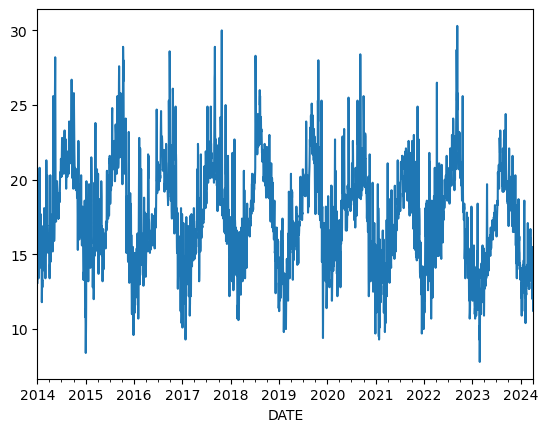

In [13]:
# from Jan 2014 to Jan 2024 LA avg temp

df = pd.read_csv('weather.csv')
tmpLats = df['LATITUDE']
df = df[['DATE', 'TAVG']]
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)  
df['TAVG'].plot()

### Dataset Preprocessed with EMA

<Axes: xlabel='DATE'>

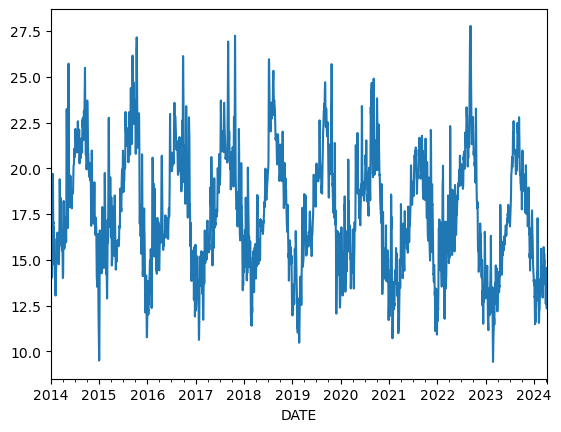

In [14]:
df['TAVG'] = df['TAVG'].ewm(span=4, adjust=False).mean()
df['TAVG'].plot()

### Check for stationarity

In [75]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

ad_test(df['TAVG'])

1. ADF :  -4.098196552899494
2. P-Value :  0.0009751937862361512
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression: 3729
5. Critical Values :
	 1% :  -3.432104842367201
	 5% :  -2.86231539241204
	 10% :  -2.567182752288834


### Error Functions

In [77]:
def mean_absolute_error(actual, forecast):
    """
    Calculate the Mean Absolute Error (MAE) between actual and forecast values.
    
    Parameters:
        actual (array-like): Array containing the actual values.
        forecast (array-like): Array containing the forecasted values.
    
    Returns:
        float: Mean Absolute Error (MAE)
    """
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Calculate absolute errors
    errors = np.abs(actual - forecast)
    
    # Calculate mean absolute error
    mae = np.mean(errors)
    
    return mae

def mean_squared_error(actual, forecast):
    """
    Calculate the Mean Squared Error (MSE) between actual and forecast values.
    
    Parameters:
        actual (array-like): Array containing the actual values.
        forecast (array-like): Array containing the forecasted values.
    
    Returns:
        float: Mean Squared Error (MSE)
    """
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Calculate squared errors
    errors = (actual - forecast) ** 2
    
    # Calculate mean squared error
    mse = np.mean(errors)
    
    return mse

### ARIMA

In [44]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [45]:
stepwise_fit = auto_arima(df['TAVG'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5223.163, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7094.907, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5784.820, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5567.456, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7092.907, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5408.094, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5339.999, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5265.953, Time=1.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5224.493, Time=1.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5438.888, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5263.260, Time=1.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5352.294, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5217.952, Time=1.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5220.938, Time=1.75 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3750
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2600.955
Date:                Mon, 06 May 2024   AIC                           5215.911
Time:                        12:30:04   BIC                           5259.516
Sample:                    01-01-2014   HQIC                          5231.419
                         - 04-07-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2371      0.022     10.884      0.000       0.194       0.280
ar.L2          0.7836      0.022     35.408      0.000       0.740       0.827
ar.L3         -0.4086      0.021    -19.041      0.000      -0.451      -0.367
ma.L1          0.4483      0.024     19.070      0.000       0.402       0.494
ma.L2         -0.8291      0.022    -38.103      0.000      -0.872      -0.786
ma.L3         -0.3097      0.022    -14.290      0.000      -0.352      -0.267
sigma2         0.2344      0.004     64.520      0.000       0.227       0.242
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1107.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.40
Prob(H) (two-sided):                  0.93   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
from statsmodels.tsa.arima.model import ARIMA
print(df.shape)
train = df.iloc[:-24]
test = df.iloc[-24:]
print(train.shape, test.shape)

(3750, 1)
(3726, 1) (24, 1)


In [47]:
model = ARIMA(train, order=(3,1,3))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TAVG   No. Observations:                 3726
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2588.644
Date:                Mon, 06 May 2024   AIC                           5191.289
Time:                        12:30:23   BIC                           5234.848
Sample:                    01-01-2014   HQIC                          5206.785
                         - 03-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2399      0.023     10.555      0.000       0.195       0.284
ar.L2          0.7808      0.024     32.476      0.000       0.734       0.828
ar.L3         -0.4072      0.022    -18.475      0.000      -0.450      -0.364
ma.L1          0.4460      0.024     18.285      0.000       0.398       0.494
ma.L2         -0.8276      0.022    -37.093      0.000      -0.871      -0.784
ma.L3         -0.3098      0.022    -14.240      0.000      -0.352      -0.267
sigma2         0.2350      0.004     64.343      0.000       0.228       0.242
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1104.28
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.40
Prob(H) (two-sided):                  0.85   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, type='levels')
pred.index = df.index[start:end+1]
print(test.shape, pred.shape)

(24, 1) (24,)


<Axes: xlabel='DATE'>

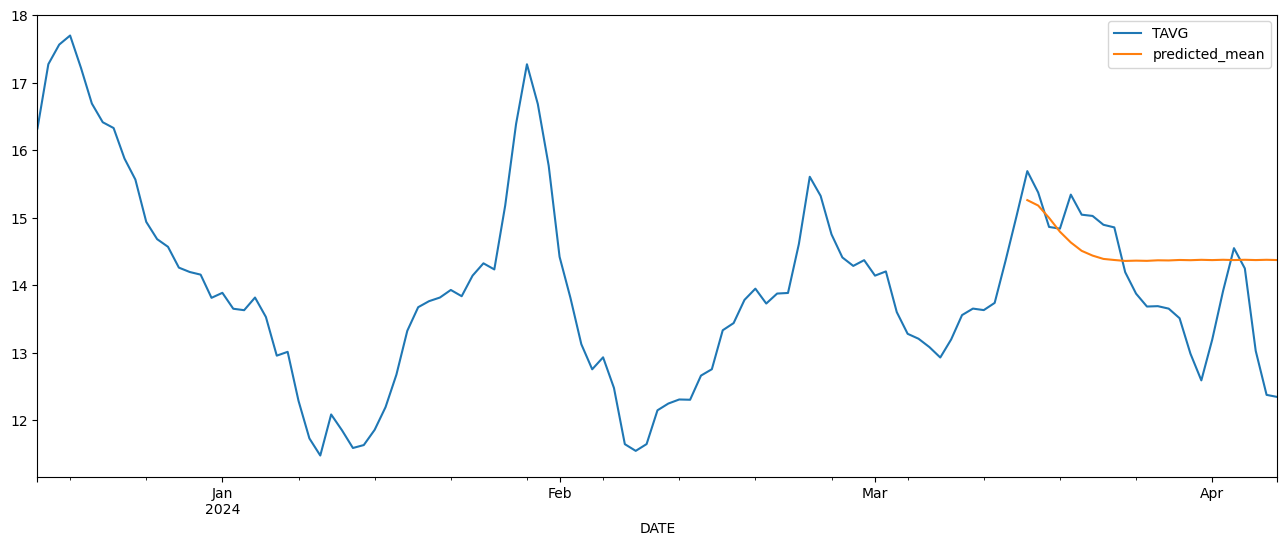

In [49]:
df['TAVG']['2023-12-15':].plot(figsize=(16, 6), legend=True)
pred.plot(legend=True)

In [50]:
print(mean_absolute_error(test, pred))
print(mean_squared_error(test, pred))

0.9052231431003906
1.1934355073099825


### SARIMAX

In [15]:
df['LATITUDE'] = tmpLats.values

In [67]:
SARIMAX_model = auto_arima(df['TAVG'], exogenous=df[['LATITUDE']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.55 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=16564.727, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8434.422, Time=1.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11612.422, Time=2.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=16562.736, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9473.761, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8032.009, Time=33.01 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=37.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.17 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=16080.430, Time=15.51 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=6462.435, Time=23.65 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=6805.861, Time=1.96 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=35.63 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3750
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood               -3071.581
Date:                             Mon, 06 May 2024   AIC                           6159.161
Time:                                     13:00:22   BIC                           6208.972
Sample:                                 01-01-2014   HQIC                          6176.879
                                      - 04-07-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1217      0.053     39.818      0.000       2.017       2.226
ar.L2         -1.5096      0.066    -22.946      0.000      -1.639      -1.381
ar.L3          0.3743      0.022     17.134      0.000       0.331       0.417
ma.L1         -0.4570      0.053     -8.543      0.000      -0.562      -0.352
ma.L2         -0.2860      0.035     -8.123      0.000      -0.355      -0.217
ar.S.L12      -0.6730      0.014    -47.586      0.000      -0.701      -0.645
ar.S.L24      -0.3217      0.014    -22.766      0.000      -0.349      -0.294
sigma2         0.3020      0.005     57.893      0.000       0.292       0.312
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               437.32
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.24
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = df.iloc[:-24]
test = df.iloc[-24:]
tmpLats = tmpLats.iloc[:-24]
tmpLatsTest = tmpLats.iloc[-24:]
train['LATITUDE'] = tmpLats.values
test['LATITUDE'] = tmpLatsTest.values

/var/folders/_d/4n0vk31j32z0fcdkk7_d5byh0000gn/T/ipykernel_37566/3449493213.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['LATITUDE'] = tmpLats.values
/var/folders/_d/4n0vk31j32z0fcdkk7_d5byh0000gn/T/ipykernel_37566/3449493213.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LATITUDE'] = tmpLatsTest.values


In [17]:
model = SARIMAX(train['TAVG'], order=(3,0,2), seasonal_order=(2,1,0,12), exog=train[['LATITUDE']])
model = model.fit()
model.summary()

/Users/shreyaskulkarni/anaconda3/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/shreyaskulkarni/anaconda3/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/shreyaskulkarni/anaconda3/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/shreyaskulkarni/anaconda3/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36779D+00    |proj g|=  1.30757D+01

At iterate    5    f=  8.84055D-01    |proj g|=  1.84503D-01

At iterate   10    f=  8.23463D-01    |proj g|=  7.65025D-03

At iterate   15    f=  8.23394D-01    |proj g|=  1.01592D-03

At iterate   20    f=  8.23366D-01    |proj g|=  9.27260D-03

At iterate   25    f=  8.22506D-01    |proj g|=  2.45465D-02

At iterate   30    f=  8.21682D-01    |proj g|=  1.24635D-02

At iterate   35    f=  8.20796D-01    |proj g|=  6.96035D-03

At iterate   40    f=  8.20296D-01    |proj g|=  1.34769D-02

At iterate   45    f=  8.20260D-01    |proj g|=  7.96045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                TAVG   No. Observations:                 3726
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood               -3056.287
Date:                             Mon, 06 May 2024   AIC                           6130.573
Time:                                     21:28:22   BIC                           6186.552
Sample:                                 01-01-2014   HQIC                          6150.491
                                      - 03-14-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LATITUDE      -0.0002   2907.314  -6.24e-08      1.000   -5698.230    5698.230
ar.L1          2.1407      0.047     45.954      0.000       2.049       2.232
ar.L2         -1.5319      0.059    -26.103      0.000      -1.647      -1.417
ar.L3          0.3796      0.021     18.232      0.000       0.339       0.420
ma.L1         -0.4740      0.047    -10.134      0.000      -0.566      -0.382
ma.L2         -0.2985      0.032     -9.195      0.000      -0.362      -0.235
ar.S.L12      -0.6744      0.014    -47.355      0.000      -0.702      -0.647
ar.S.L24      -0.3239      0.014    -22.847      0.000      -0.352      -0.296
sigma2         0.3029      0.005     57.686      0.000       0.293       0.313
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               436.13
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.24
Prob(H) (two-sided):                  0.87   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, type='levels', exog=test[['LATITUDE']])
pred.index = df.index[start:end+1]
print(test.shape, pred.shape)

(24, 2) (24,)


/Users/shreyaskulkarni/anaconda3/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='DATE'>

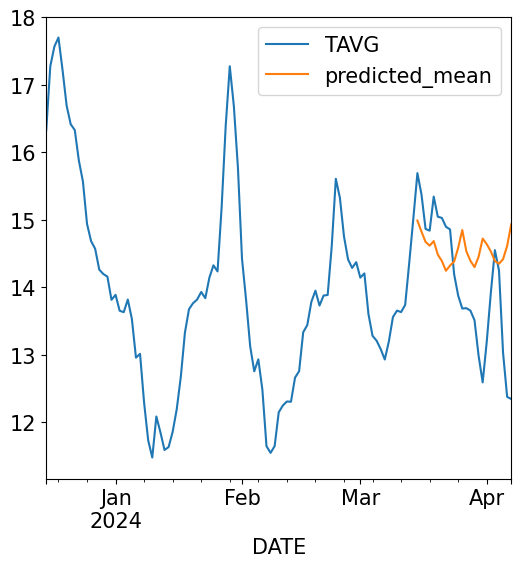

In [25]:
df['TAVG']['2023-12-15':].plot(figsize=(16, 6), legend=True)
pred.plot(legend=True)

In [72]:
print(mean_absolute_error(test['TAVG'], pred))
print(mean_squared_error(test['TAVG'], pred))

0.8856248443834408
1.2206773438402163


### Meta Prophet

In [144]:
from prophet import Prophet

In [145]:
model = Prophet()#changepoint_prior_scale=0.01)

In [146]:
train = df.iloc[:-24]
test = df.iloc[-24:]
train_data = train['TAVG']

df2 = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
model.fit(df2)

13:07:22 - cmdstanpy - INFO - Chain [1] start processing
13:07:22 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
test_dataset = test['TAVG']

# future = model.make_future_dataframe(periods=len(test_dataset)*15, freq='d')
future = model.make_future_dataframe(periods=24, freq='d')
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,18.709311,12.132632,17.268969,18.709311,18.709311,-4.047465,-4.047465,-4.047465,-0.035765,-0.035765,-0.035765,-4.011700,-4.011700,-4.011700,0.0,0.0,0.0,14.661846
1,2014-01-02,18.708408,12.012565,17.281991,18.708408,18.708408,-3.974411,-3.974411,-3.974411,0.018147,0.018147,0.018147,-3.992557,-3.992557,-3.992557,0.0,0.0,0.0,14.733998
2,2014-01-03,18.707506,12.229116,17.517744,18.707506,18.707506,-3.885874,-3.885874,-3.885874,0.080489,0.080489,0.080489,-3.966363,-3.966363,-3.966363,0.0,0.0,0.0,14.821631
3,2014-01-04,18.706603,12.184888,17.316017,18.706603,18.706603,-3.915148,-3.915148,-3.915148,0.018407,0.018407,0.018407,-3.933556,-3.933556,-3.933556,0.0,0.0,0.0,14.791455
4,2014-01-05,18.705700,12.241469,17.371262,18.705700,18.705700,-3.924406,-3.924406,-3.924406,-0.029774,-0.029774,-0.029774,-3.894632,-3.894632,-3.894632,0.0,0.0,0.0,14.781294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,2024-04-03,16.743335,12.118526,17.491748,16.743335,16.743335,-1.984245,-1.984245,-1.984245,-0.035765,-0.035765,-0.035765,-1.948479,-1.948479,-1.948479,0.0,0.0,0.0,14.759090
3746,2024-04-04,16.742737,12.386059,17.549604,16.742737,16.742737,-1.908465,-1.908465,-1.908465,0.018147,0.018147,0.018147,-1.926612,-1.926612,-1.926612,0.0,0.0,0.0,14.834273
3747,2024-04-05,16.742140,12.305211,17.550608,16.742140,16.742140,-1.821397,-1.821397,-1.821397,0.080489,0.080489,0.080489,-1.901886,-1.901886,-1.901886,0.0,0.0,0.0,14.920743
3748,2024-04-06,16.741543,12.309661,17.458937,16.741543,16.741543,-1.855524,-1.855524,-1.855524,0.018407,0.018407,0.018407,-1.873931,-1.873931,-1.873931,0.0,0.0,0.0,14.886019


In [148]:
forecast.rename(columns = {'ds':'DATE'}, inplace = True) 
forecast.set_index('DATE', inplace=True)
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
DATE,,,,,,,,,,,,,,,,,,
2014-01-01,18.709311,12.132632,17.268969,18.709311,18.709311,-4.047465,-4.047465,-4.047465,-0.035765,-0.035765,-0.035765,-4.011700,-4.011700,-4.011700,0.0,0.0,0.0,14.661846
2014-01-02,18.708408,12.012565,17.281991,18.708408,18.708408,-3.974411,-3.974411,-3.974411,0.018147,0.018147,0.018147,-3.992557,-3.992557,-3.992557,0.0,0.0,0.0,14.733998
2014-01-03,18.707506,12.229116,17.517744,18.707506,18.707506,-3.885874,-3.885874,-3.885874,0.080489,0.080489,0.080489,-3.966363,-3.966363,-3.966363,0.0,0.0,0.0,14.821631
2014-01-04,18.706603,12.184888,17.316017,18.706603,18.706603,-3.915148,-3.915148,-3.915148,0.018407,0.018407,0.018407,-3.933556,-3.933556,-3.933556,0.0,0.0,0.0,14.791455
2014-01-05,18.705700,12.241469,17.371262,18.705700,18.705700,-3.924406,-3.924406,-3.924406,-0.029774,-0.029774,-0.029774,-3.894632,-3.894632,-3.894632,0.0,0.0,0.0,14.781294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03,16.743335,12.118526,17.491748,16.743335,16.743335,-1.984245,-1.984245,-1.984245,-0.035765,-0.035765,-0.035765,-1.948479,-1.948479,-1.948479,0.0,0.0,0.0,14.759090
2024-04-04,16.742737,12.386059,17.549604,16.742737,16.742737,-1.908465,-1.908465,-1.908465,0.018147,0.018147,0.018147,-1.926612,-1.926612,-1.926612,0.0,0.0,0.0,14.834273
2024-04-05,16.742140,12.305211,17.550608,16.742140,16.742140,-1.821397,-1.821397,-1.821397,0.080489,0.080489,0.080489,-1.901886,-1.901886,-1.901886,0.0,0.0,0.0,14.920743


<Axes: xlabel='DATE'>

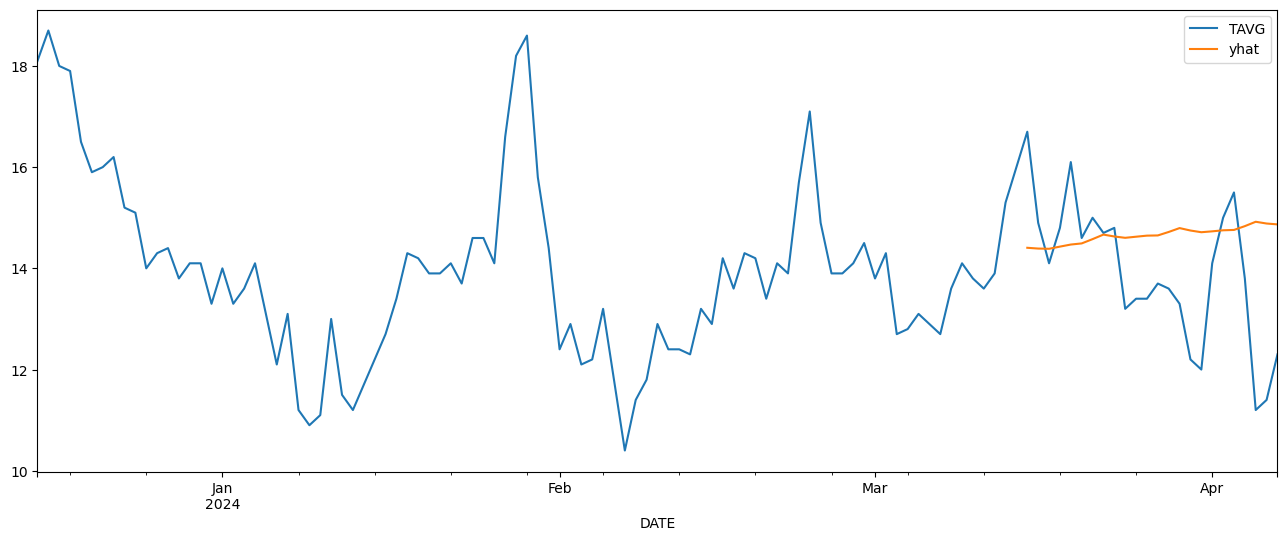

In [149]:
df['TAVG']['2023-12-15':].plot(figsize=(16, 6), legend=True)
forecast['yhat'][-24:].plot(legend=True)

In [150]:
print(mean_absolute_error(test['TAVG'], forecast['yhat'].tail(24)))
print(mean_squared_error(test['TAVG'], forecast['yhat'].tail(24)))

1.2897715948340955
2.7734316925946914


# Electricity Dataset

### Dataset

<Axes: xlabel='DATE'>

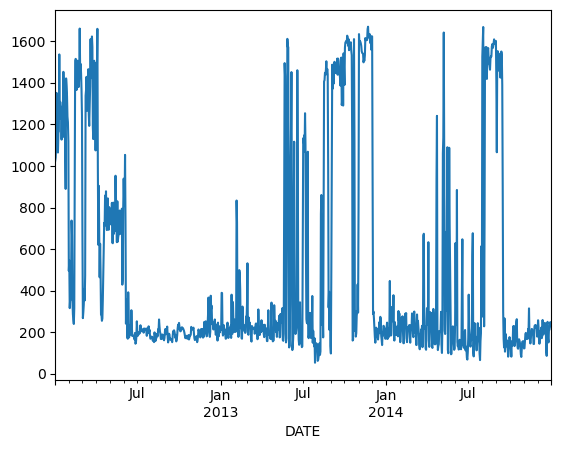

In [175]:
df = pd.read_csv('electricity.csv')
df = df[['DATE', 'MT_001']]
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)
df.set_index('DATE', inplace=True)  
df['MT_001'].plot()

### Dataset Preprocessed with EMA

<Axes: xlabel='DATE'>

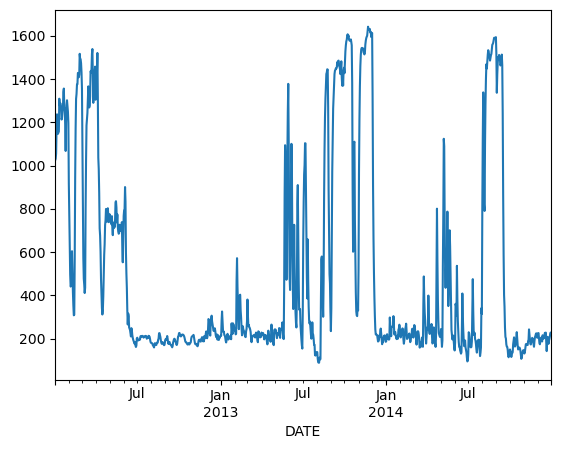

In [176]:
df['MT_001'] = df['MT_001'].ewm(span=4, adjust=False).mean()
df['MT_001'].plot()

### Check for stationarity

In [177]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

ad_test(df['MT_001'])

1. ADF :  -4.133701940696962
2. P-Value :  0.0008514823941306358
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression: 1085
5. Critical Values :
	 1% :  -3.436391325753478
	 5% :  -2.864207498909067
	 10% :  -2.5681902663042324


### Error Functions

In [178]:
def mean_absolute_error(actual, forecast):
    """
    Calculate the Mean Absolute Error (MAE) between actual and forecast values.
    
    Parameters:
        actual (array-like): Array containing the actual values.
        forecast (array-like): Array containing the forecasted values.
    
    Returns:
        float: Mean Absolute Error (MAE)
    """
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Calculate absolute errors
    errors = np.abs(actual - forecast)
    
    # Calculate mean absolute error
    mae = np.mean(errors)
    
    return mae

def mean_squared_error(actual, forecast):
    """
    Calculate the Mean Squared Error (MSE) between actual and forecast values.
    
    Parameters:
        actual (array-like): Array containing the actual values.
        forecast (array-like): Array containing the forecasted values.
    
    Returns:
        float: Mean Squared Error (MSE)
    """
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Calculate squared errors
    errors = (actual - forecast) ** 2
    
    # Calculate mean squared error
    mse = np.mean(errors)
    
    return mse

### ARIMA

In [179]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [180]:
stepwise_fit = auto_arima(df['MT_001'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12541.775, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12987.080, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12650.590, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12586.063, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12985.150, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12564.304, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12539.788, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12566.463, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12540.398, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12541.788, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12540.070, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12539.177, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12532.125, Time=0.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12536.991, Time=0.29 sec
 ARIMA(5,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -6252.058
Date:                Mon, 06 May 2024   AIC                          12518.116
Time:                        13:14:58   BIC                          12553.100
Sample:                    01-02-2012   HQIC                         12531.354
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5180      0.058     26.114      0.000       1.404       1.632
ar.L2         -1.2822      0.063    -20.411      0.000      -1.405      -1.159
ar.L3          0.2653      0.044      5.983      0.000       0.178       0.352
ma.L1         -0.8696      0.056    -15.450      0.000      -0.980      -0.759
ma.L2          0.4389      0.041     10.734      0.000       0.359       0.519
ma.L3          0.2918      0.036      8.023      0.000       0.221       0.363
sigma2      5433.5744    102.642     52.937      0.000    5232.400    5634.748
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3757.38
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [181]:
from statsmodels.tsa.arima.model import ARIMA
print(df.shape)
train = df.iloc[:-24]
test = df.iloc[-24:]
print(train.shape, test.shape)

(1095, 1)
(1071, 1) (24, 1)


In [182]:
model = ARIMA(train, order=(3,1,3))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 MT_001   No. Observations:                 1071
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -6125.963
Date:                Mon, 06 May 2024   AIC                          12265.925
Time:                        13:15:08   BIC                          12300.753
Sample:                    01-02-2012   HQIC                         12279.119
                         - 12-07-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5167      0.060     25.077      0.000       1.398       1.635
ar.L2         -1.2793      0.065    -19.661      0.000      -1.407      -1.152
ar.L3          0.2647      0.046      5.781      0.000       0.175       0.354
ma.L1         -0.8669      0.059    -14.794      0.000      -0.982      -0.752
ma.L2          0.4339      0.042     10.350      0.000       0.352       0.516
ma.L3          0.2911      0.037      7.808      0.000       0.218       0.364
sigma2      5566.3378    107.631     51.717      0.000    5355.386    5777.290
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3496.29
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [183]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, type='levels')
pred.index = df.index[start:end+1]
print(test.shape, pred.shape)

(24, 1) (24,)


<Axes: xlabel='DATE'>

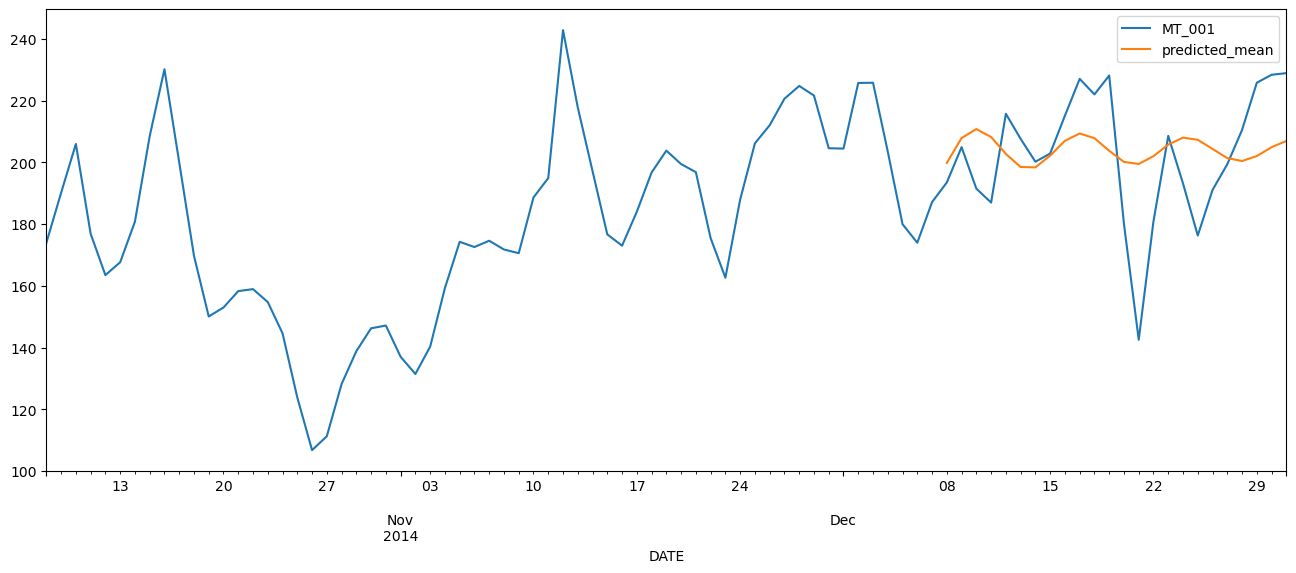

In [184]:
df['MT_001']['2014-10-08':].plot(figsize=(16, 6), legend=True)
pred.plot(legend=True)

In [185]:
print(mean_absolute_error(test, pred))
print(mean_squared_error(test, pred))

16.255819340622477
430.0897920384623


### SARIMAX

In [186]:
SARIMAX_model = auto_arima(df['MT_001'],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=16021.066, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=13338.869, Time=0.97 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=16019.880, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=13658.560, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=13175.321, Time=7.48 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=15933.128, Time=4.98 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=12792.473, Time=9.33 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=12930.685, Time=0.99 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=12.71 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1095
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -6352.602
Date:                            Mon, 06 May 2024   AIC                          12717.205
Time:                                    13:18:03   BIC                          12747.130
Sample:                                01-02-2012   HQIC                         12728.534
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6364      0.020     80.863      0.000       1.597       1.676
ar.L2         -0.9359      0.032    -29.475      0.000      -0.998      -0.874
ar.L3          0.2598      0.018     14.495      0.000       0.225       0.295
ar.S.L12      -0.6710      0.021    -31.757      0.000      -0.712      -0.630
ar.S.L24      -0.3416      0.019    -18.302      0.000      -0.378      -0.305
sigma2      7215.3002    164.994     43.731      0.000    6891.918    7538.683
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1588.42
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [187]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = df.iloc[:-24]
test = df.iloc[-24:]

In [188]:
model = SARIMAX(train['MT_001'], order=(3,0,0), seasonal_order=(2,1,0,12))
model = model.fit()
model.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89945D+00    |proj g|=  2.59687D-01

At iterate    5    f=  5.84832D+00    |proj g|=  1.60167D-02

At iterate   10    f=  5.84539D+00    |proj g|=  3.11009D-03

At iterate   15    f=  5.84197D+00    |proj g|=  2.69849D-02

At iterate   20    f=  5.82589D+00    |proj g|=  1.46980D-02

At iterate   25    f=  5.82505D+00    |proj g|=  2.18463D-02
  ys=-2.171E-04  -gs= 2.866E-03 BFGS update SKIPPED

At iterate   30    f=  5.81134D+00    |proj g|=  2.87846D-02

At iterate   35    f=  5.81036D+00    |proj g|=  1.35917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             MT_001   No. Observations:                 1071
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -6222.896
Date:                            Mon, 06 May 2024   AIC                          12457.792
Time:                                    13:18:15   BIC                          12487.583
Sample:                                01-02-2012   HQIC                         12469.083
                                     - 12-07-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6371      0.021     79.237      0.000       1.597       1.678
ar.L2         -0.9367      0.032    -28.894      0.000      -1.000      -0.873
ar.L3          0.2600      0.018     14.206      0.000       0.224       0.296
ar.S.L12      -0.6708      0.022    -31.107      0.000      -0.713      -0.629
ar.S.L24      -0.3417      0.019    -17.940      0.000      -0.379      -0.304
sigma2      7365.3385    172.170     42.779      0.000    7027.891    7702.786
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1466.34
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [189]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, type='levels')
pred.index = df.index[start:end+1]
print(test.shape, pred.shape)

(24, 1) (24,)


<Axes: xlabel='DATE'>

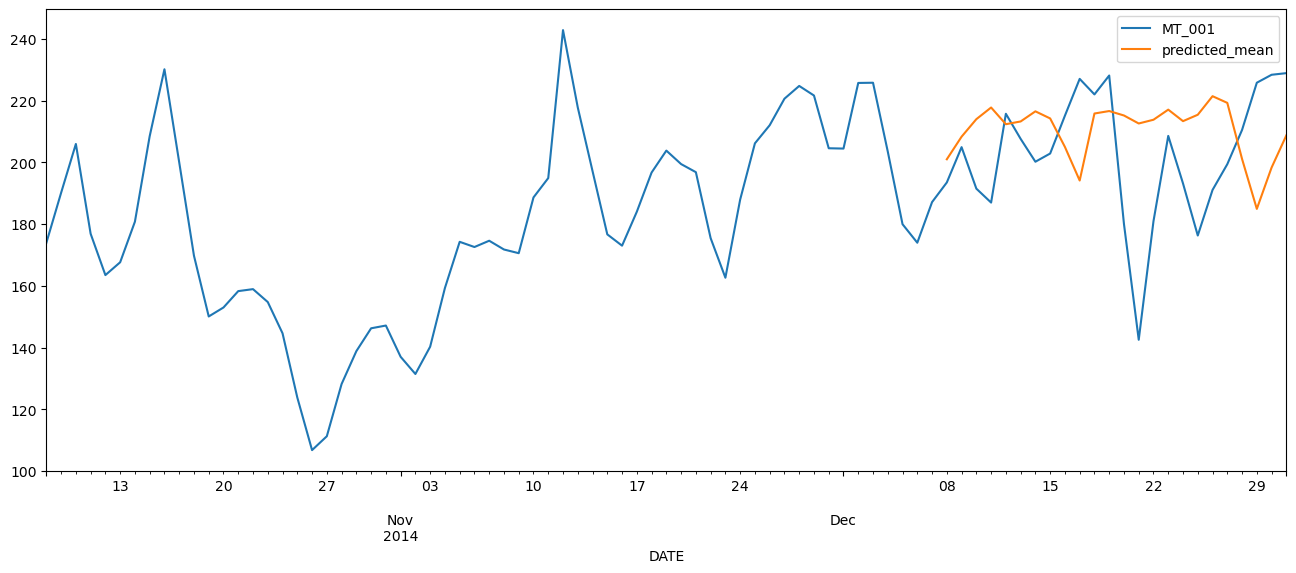

In [190]:
df['MT_001']['2014-10-08':].plot(figsize=(16, 6), legend=True)
pred.plot(legend=True)

In [191]:
print(mean_absolute_error(test, pred))
print(mean_squared_error(test, pred))

18.240430642697156
550.9189984117224


### Meta Prophet

In [192]:
from prophet import Prophet

In [193]:
model = Prophet()#changepoint_prior_scale=0.01)

In [194]:
train = df.iloc[:-24]
test = df.iloc[-24:]
train_data = train['MT_001']

df2 = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
model.fit(df2)

13:18:52 - cmdstanpy - INFO - Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing


In [195]:
test_dataset = test['MT_001']

# future = model.make_future_dataframe(periods=len(test_dataset)*15, freq='d')
future = model.make_future_dataframe(periods=24, freq='d')
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-02,1390.336406,738.797615,1586.857875,1390.336406,1390.336406,-228.841173,-228.841173,-228.841173,-19.406791,-19.406791,-19.406791,-209.434382,-209.434382,-209.434382,0.0,0.0,0.0,1161.495234
1,2012-01-03,1385.205240,729.081457,1596.535253,1385.205240,1385.205240,-195.248228,-195.248228,-195.248228,-0.460820,-0.460820,-0.460820,-194.787408,-194.787408,-194.787408,0.0,0.0,0.0,1189.957012
2,2012-01-04,1380.074074,801.790638,1629.549008,1380.074074,1380.074074,-165.370049,-165.370049,-165.370049,15.637025,15.637025,15.637025,-181.007074,-181.007074,-181.007074,0.0,0.0,0.0,1214.704025
3,2012-01-05,1374.942908,795.260885,1636.176898,1374.942908,1374.942908,-151.963088,-151.963088,-151.963088,16.430680,16.430680,16.430680,-168.393768,-168.393768,-168.393768,0.0,0.0,0.0,1222.979820
4,2012-01-06,1369.811742,789.819070,1624.269463,1369.811742,1369.811742,-137.905411,-137.905411,-137.905411,19.305825,19.305825,19.305825,-157.211235,-157.211235,-157.211235,0.0,0.0,0.0,1231.906332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2014-12-27,175.799445,-538.811466,304.555776,173.171757,178.123643,-299.669887,-299.669887,-299.669887,-6.935715,-6.935715,-6.935715,-292.734172,-292.734172,-292.734172,0.0,0.0,0.0,-123.870442
1091,2014-12-28,174.471835,-534.302486,266.528207,171.688228,177.011706,-304.643393,-304.643393,-304.643393,-24.570203,-24.570203,-24.570203,-280.073190,-280.073190,-280.073190,0.0,0.0,0.0,-130.171558
1092,2014-12-29,173.144224,-505.480366,298.838244,170.119104,175.994949,-285.572888,-285.572888,-285.572888,-19.406791,-19.406791,-19.406791,-266.166097,-266.166097,-266.166097,0.0,0.0,0.0,-112.428664
1093,2014-12-30,171.816613,-475.000677,339.327359,168.343326,174.903873,-251.854658,-251.854658,-251.854658,-0.460820,-0.460820,-0.460820,-251.393838,-251.393838,-251.393838,0.0,0.0,0.0,-80.038045


In [196]:
forecast.rename(columns = {'ds':'DATE'}, inplace = True) 
forecast.set_index('DATE', inplace=True)
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
DATE,,,,,,,,,,,,,,,,,,
2012-01-02,1390.336406,738.797615,1586.857875,1390.336406,1390.336406,-228.841173,-228.841173,-228.841173,-19.406791,-19.406791,-19.406791,-209.434382,-209.434382,-209.434382,0.0,0.0,0.0,1161.495234
2012-01-03,1385.205240,729.081457,1596.535253,1385.205240,1385.205240,-195.248228,-195.248228,-195.248228,-0.460820,-0.460820,-0.460820,-194.787408,-194.787408,-194.787408,0.0,0.0,0.0,1189.957012
2012-01-04,1380.074074,801.790638,1629.549008,1380.074074,1380.074074,-165.370049,-165.370049,-165.370049,15.637025,15.637025,15.637025,-181.007074,-181.007074,-181.007074,0.0,0.0,0.0,1214.704025
2012-01-05,1374.942908,795.260885,1636.176898,1374.942908,1374.942908,-151.963088,-151.963088,-151.963088,16.430680,16.430680,16.430680,-168.393768,-168.393768,-168.393768,0.0,0.0,0.0,1222.979820
2012-01-06,1369.811742,789.819070,1624.269463,1369.811742,1369.811742,-137.905411,-137.905411,-137.905411,19.305825,19.305825,19.305825,-157.211235,-157.211235,-157.211235,0.0,0.0,0.0,1231.906332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,175.799445,-538.811466,304.555776,173.171757,178.123643,-299.669887,-299.669887,-299.669887,-6.935715,-6.935715,-6.935715,-292.734172,-292.734172,-292.734172,0.0,0.0,0.0,-123.870442
2014-12-28,174.471835,-534.302486,266.528207,171.688228,177.011706,-304.643393,-304.643393,-304.643393,-24.570203,-24.570203,-24.570203,-280.073190,-280.073190,-280.073190,0.0,0.0,0.0,-130.171558
2014-12-29,173.144224,-505.480366,298.838244,170.119104,175.994949,-285.572888,-285.572888,-285.572888,-19.406791,-19.406791,-19.406791,-266.166097,-266.166097,-266.166097,0.0,0.0,0.0,-112.428664


<Axes: xlabel='DATE'>

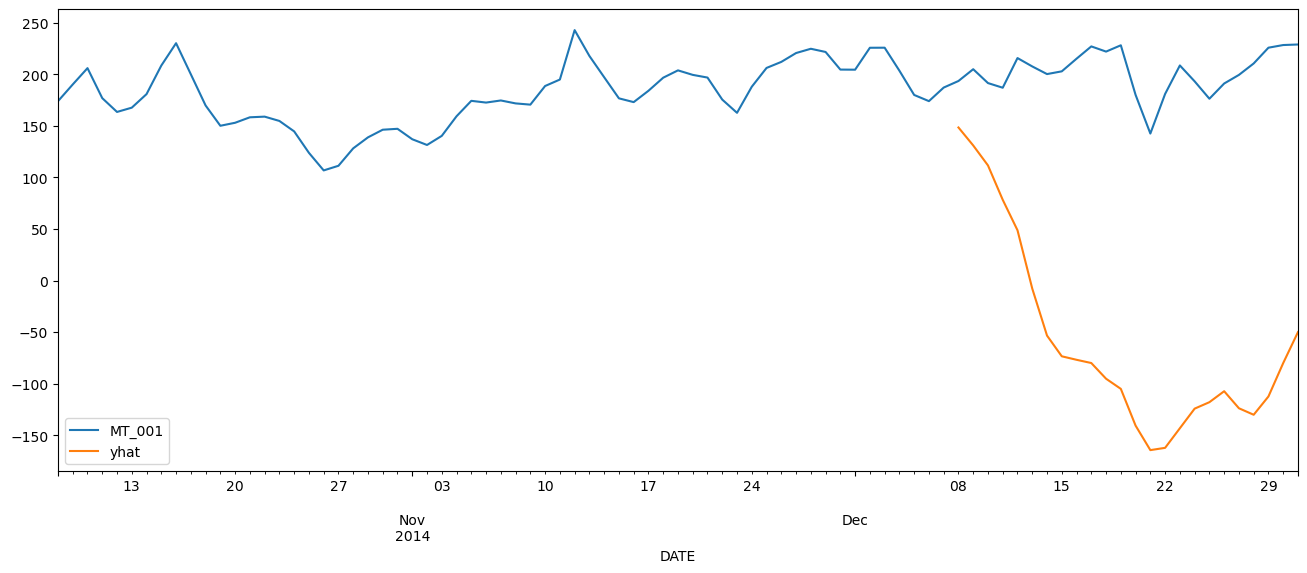

In [197]:
df['MT_001']['2014-10-08':].plot(figsize=(16, 6), legend=True)
forecast['yhat'][-24:].plot(legend=True)

In [198]:
print(mean_absolute_error(test['MT_001'], forecast['yhat'].tail(24)))
print(mean_squared_error(test['MT_001'], forecast['yhat'].tail(24)))

262.15317603235786
77282.46348593409
